# <font color='red'> Spoken Digit Recognition</font>


In this notebook, You will do Spoken Digit Recognition. 

Input - speech signal, output - digit number



It contains  

1. Reading the dataset. and Preprocess the data set. Detailed instrctions are given below. You have to write the code in the same cell which contains the instrction. 
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  

<font size=5>Instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. Please return outputs in the same format what we asked. Eg. Don't return List of we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>



In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import matplotlib.pyplot as plt
##if you need any imports you can do that here. 

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

We shared recordings.zip, please unzip those. 

In [2]:
# import OS module
import os

all_files = []
path = "/kaggle/input/spoken-digit-rec/recordings"
dir_list = os.listdir(path)

for files in dir_list:
    res = os.path.join(path, files)
    all_files.append(res)
    
len(all_files)

2000

<font size=4>Grader function 1 </font>

In [3]:
def grader_files():
    temp = len(all_files)==2000
    temp1 = all([x[-3:]=="wav" for x in all_files])
    temp = temp and temp1
    return temp
grader_files()

True

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

## Exploring the sound dataset

In [4]:
#It is a good programming practise to explore the dataset that you are dealing with. This dataset is unique in itself because it has sounds as input
#https://colab.research.google.com/github/Tyler-Hilbert/AudioProcessingInPythonWorkshop/blob/master/AudioProcessingInPython.ipynb
#visualize the data and write code to play 2-3 sound samples in the notebook for better understanding.
#please go through the following reference video https://www.youtube.com/watch?v=37zCgCdV468

## Creating dataframe

In [5]:
#Create a dataframe(name=df_audio) with two columns(path, label).   
#You can get the label from the first letter of name.  
#Eg: 0_jackson_0 --> 0  
#0_jackson_43 --> 0
label = []

for i in os.listdir(path):
    label.append(int(i[0]))
    
len(label)


2000

In [6]:
df_audio = pd.DataFrame({'path' : all_files, 'label' : label})
df_audio.head()

,path,label
0,/kaggle/input/spoken-digit-rec/recordings/0_yw...,0
1,/kaggle/input/spoken-digit-rec/recordings/1_yw...,1
2,/kaggle/input/spoken-digit-rec/recordings/0_ni...,0
3,/kaggle/input/spoken-digit-rec/recordings/6_ni...,6
4,/kaggle/input/spoken-digit-rec/recordings/1_th...,1


In [7]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


<font size=4>Grader function 2 </font>

In [8]:
def grader_df():
    flag_shape = df_audio.shape==(2000,2)
    flag_columns = all(df_audio.columns==['path', 'label'])
    list_values = list(df_audio.label.value_counts())
    flag_label = len(list_values)==10
    flag_label2 = all([i==200 for i in list_values])
    final_flag = flag_shape and flag_columns and flag_label and flag_label2
    return final_flag
grader_df()

True

In [9]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [10]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%
from sklearn.model_selection import train_test_split

X = df_audio['path']
y = df_audio['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=45)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400,), (600,), (1400,), (600,))

<font size=4>Grader function 3 </font>

In [11]:
def grader_split():
    flag_len = (len(X_train)==1400) and (len(X_test)==600) and (len(y_train)==1400) and (len(y_test)==600)
    values_ytrain = list(y_train.value_counts())
    flag_ytrain = (len(values_ytrain)==10) and (all([i==140 for i in values_ytrain]))
    values_ytest = list(y_test.value_counts())
    flag_ytest = (len(values_ytest)==10) and (all([i==60 for i in values_ytest]))
    final_flag = flag_len and flag_ytrain and flag_ytest
    return final_flag
grader_split()

True

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [12]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [13]:
#use load_wav function that was written above to get every wave. 
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train
from tqdm import tqdm

train_samples = []
train_duration = []
test_samples = []
test_duration = []

for i in X_train:
    train_samples.append(np.array(load_wav(i)[0]))
    train_duration.append(load_wav(i)[1])
    
for j in X_test:
    test_samples.append(np.array(load_wav(j)[0]))
    test_duration.append(load_wav(j)[1])
    
X_train_processed = pd.DataFrame({'raw_data' : train_samples, 'duration' : train_duration})
X_test_processed = pd.DataFrame({'raw_data' : test_samples, 'duration' : test_duration})

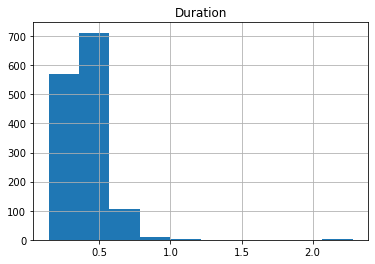

In [14]:
#plot the histogram of the duration for train
plt.hist(X_train_processed['duration'])
plt.grid()
plt.title('Duration')
plt.show()

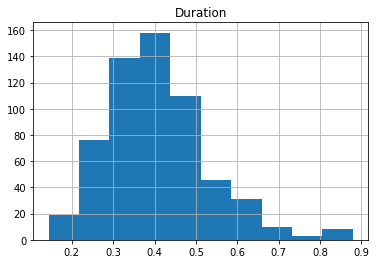

In [15]:
#plot the histogram of the duration for test
plt.hist(X_test_processed['duration'])
plt.grid()
plt.title('Duration')
plt.show()

In [16]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 
for i in range(0, 101, 10):
    p = np.percentile(X_train_processed['duration'], i)
    print(i, 'th percentile is ', p)

0 th percentile is  0.1435374149659864
10 th percentile is  0.2591020408163265
20 th percentile is  0.297750566893424
30 th percentile is  0.33048072562358277
40 th percentile is  0.35586394557823126
50 th percentile is  0.38589569160997733
60 th percentile is  0.413124716553288
70 th percentile is  0.4444671201814059
80 th percentile is  0.4813424036281179
90 th percentile is  0.5528934240362812
100 th percentile is  2.282766439909297


In [17]:
# print 90 to 100 percentile values with step size of 1. 
for i in range(90, 101):
    p = np.percentile(X_train_processed['duration'], i)
    print(i, 'th percentile is ', p)

90 th percentile is  0.5528934240362812
91 th percentile is  0.561917006802721
92 th percentile is  0.5759256235827664
93 th percentile is  0.5915578231292521
94 th percentile is  0.6101587301587301
95 th percentile is  0.622421768707483
96 th percentile is  0.6385142857142857
97 th percentile is  0.6582875283446712
98 th percentile is  0.6883972789115647
99 th percentile is  0.7654394557823128
100 th percentile is  2.282766439909297


<font size=4>Grader function 4 </font>

In [18]:
def grader_processed():
    flag_columns = (all(X_train_processed.columns==['raw_data', 'duration'])) and (all(X_test_processed.columns==['raw_data', 'duration']))
    flag_shape = (X_train_processed.shape ==(1400, 2)) and (X_test_processed.shape==(600,2))
    return flag_columns and flag_shape
grader_processed()

True

<b>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset.</b>

<b>While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640
</b>
<b>Pad with Zero if length of sequence is less than 17640 else Truncate the number. </b>

<b> Also create a masking vector for train and test. </b>

<b> masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.</b>


In [19]:
max_length  = 17640

In [20]:
from tqdm import tqdm
X_train_pad_seq = []  
X_train_mask = []        

for i in tqdm(range(X_train_processed.shape[0])):
    if len(X_train_processed['raw_data'].values[i]) > max_length:
        pad = X_train_processed['raw_data'].values[i].tolist()[:max_length]
        
    else:
        pad = X_train_processed['raw_data'].values[i].tolist() + [0 for j in range(max_length - len(X_train_processed['raw_data'].values[i]))] 
        
  
    mask=[0 if i==0 else 1 for i in pad]
    mask=[bool(i) for i in mask]
    X_train_pad_seq.append(pad)
    X_train_mask.append(mask)

100%|██████████| 1400/1400 [00:06<00:00, 232.66it/s]


In [21]:
X_test_pad_seq = []  
X_test_mask = []        

for i in tqdm(range(X_test_processed.shape[0])):
    if len(X_test_processed['raw_data'].values[i]) > max_length:
        pad = X_test_processed['raw_data'].values[i].tolist()[:max_length]
        
    else:
        pad = X_test_processed['raw_data'].values[i].tolist() + [0 for j in range(max_length - len(X_test_processed['raw_data'].values[i]))] 
        
  
    mask=[0 if i==0 else 1 for x in pad]
    mask=[bool(i) for i in mask]
    X_test_pad_seq.append(pad)
    X_test_mask.append(mask)

X_train_pad_seq = np.array(X_train_pad_seq)
X_train_mask = np.array(X_train_mask)
X_test_pad_seq = np.array(X_test_pad_seq)
X_test_mask = np.array(X_test_mask)

100%|██████████| 600/600 [00:02<00:00, 230.66it/s]


<font size=4>Grader function 5 </font>

In [22]:
def grader_padoutput():
    flag_padshape = (X_train_pad_seq.shape==(1400, 17640)) and (X_test_pad_seq.shape==(600, 17640)) and (y_train.shape==(1400,))
    flag_maskshape = (X_train_mask.shape==(1400, 17640)) and (X_test_mask.shape==(600, 17640)) and (y_test.shape==(600,))
    flag_dtype = (X_train_mask.dtype==bool) and (X_test_mask.dtype==bool)
    return flag_padshape and flag_maskshape and flag_dtype
grader_padoutput()

True

### 1. Giving Raw data directly. 


Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. You can use any number of LSTM cells. Please read LSTM documentation(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) in tensorflow to know more about mask and also https://www.tensorflow.org/guide/keras/masking_and_padding 
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors). Also check the datatype of class labels(y_values) and make sure that you convert your class labels  to integer datatype before fitting in the model.
3. While defining your model make sure that you pass both the input layer and mask input layer as input to lstm layer as follows
<img src='https://i.imgur.com/FvcgvbY.jpg'>
4. Use tensorboard to plot the graphs of loss and metric(use custom micro F1 score as metric) and histograms of gradients. You can write your code for computing F1 score using this <a  href='https://i.imgur.com/8YULUcu.jpg'>link</a> 

5. make sure that it won't overfit. 
6. You are free to include any regularization


In [23]:
import tensorflow as tf
from sklearn.metrics import f1_score

class Score(tf.keras.callbacks.Callback):        
    
    def on_train_begin(self,logs={}):
        self.f1 = []
        self.val_f1 = []
     
    def on_epoch_end(self,epoch,logs={}):
        pred_train = np.argmax(self.model.predict([X_train_pad_seq,X_train_mask]),axis=1)
        pred_test = np.argmax(self.model.predict([X_test_pad_seq,X_test_mask]),axis=1)
        
        train_f1 = f1_score(y_train, pred_train, average="micro")
        test_f1 = f1_score(y_test, pred_test, average="micro")
        
        print("f1_score: ",train_f1, " - val_f1_score: ", test_f1)
        
        self.f1.append(train_f1)
        self.val_f1.append(test_f1)

f1 = Score()

In [24]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

In [25]:
## as discussed above, please write the architecture of the model.
## you will have two input layers in your model (data input layer and mask input layer)
## make sure that you have defined the data type of masking layer as bool
## as discussed above, please write the LSTM

input_layer = Input(shape=(17640,1))
mask_input = Input(shape=(17640,), dtype=bool)

LSTM_layer = LSTM(75)(inputs=input_layer, mask=mask_input)

dense_1 = Dense(32)(LSTM_layer)
drop = Dropout(0.5)(dense_1)
bn = BatchNormalization()(drop)

dense_2 = Dense(16)(bn)
output = Dense(10, activation="softmax")(dense_2)

model_1 = Model(inputs=[input_layer, mask_input],outputs=[output])
model_1.summary()

2023-01-26 10:28:09.837190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 10:28:09.847241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 10:28:09.848022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 10:28:09.849508: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 17640)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 75)           23100       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           2432        lstm[0][0]                   

In [26]:
import os
import datetime

! rm -rf ./logs/ 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2023-01-26 10:28:12.766270: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 10:28:12.766328: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-26 10:28:12.766411: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2023-01-26 10:28:12.958704: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 10:28:12.958880: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [27]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [28]:
callback_lst = [f1, tensorboard_callback]
model_1.fit([X_train_pad_seq,X_train_mask],y_train, epochs=2, validation_data=([X_test_pad_seq,X_test_mask],y_test), batch_size=32, callbacks=callback_lst)

2023-01-26 10:28:13.400608: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2023-01-26 10:28:16.786145: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/44 [..............................] - ETA: 3:17 - loss: 2.3025 - accuracy: 0.0625

2023-01-26 10:28:18.109160: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 10:28:18.109207: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/44 [>.............................] - ETA: 47s - loss: 2.2925 - accuracy: 0.1406 

2023-01-26 10:28:19.142504: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-26 10:28:19.188995: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-26 10:28:19.323793: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 64623 callback api events and 64620 activity events. 
2023-01-26 10:28:20.441335: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 10:28:22.620372: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20230126-102812/train/plugins/profile/2023_01_26_10_28_20

2023-01-26 10:28:23.803629: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/20230126-102812/train/plugins/profile/2023_01_26_10_28_20/5dfbba354824.trace.json.gz
2023-01-26 10:28:24.604936: I tensorflow/core/profiler/rpc/client/save_profile.cc:136]

44/44 [==============================] - 46s 975ms/step - loss: 2.3310 - accuracy: 0.1129 - val_loss: 2.3027 - val_accuracy: 0.1000
f1_score:  0.10000000000000002  - val_f1_score:  0.10000000000000002
Epoch 2/2
44/44 [==============================] - 34s 780ms/step - loss: 2.3248 - accuracy: 0.1029 - val_loss: 2.3026 - val_accuracy: 0.1000
f1_score:  0.10285714285714286  - val_f1_score:  0.10000000000000002


In [29]:
%load_ext tensorboard
%tensorboard --logdir $logdir

### 2. Converting into spectrogram and giving spectrogram data as input  

We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram


In [30]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [31]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram = []
X_test_spectrogram = []

for i in tqdm(X_train_pad_seq):
    X_train_spectrogram.append(convert_to_spectrogram(i))
    
for j in tqdm(X_test_pad_seq):
    X_test_spectrogram.append(convert_to_spectrogram(j))
    
X_train_spectrogram = np.array(X_train_spectrogram)
X_test_spectrogram = np.array(X_test_spectrogram)

100%|██████████| 600/600 [00:03<00:00, 151.55it/s]


<font size=4>Grader function 6 </font>

In [32]:
def grader_spectrogram():
    flag_shape = (X_train_spectrogram.shape==(1400,64, 35)) and (X_test_spectrogram.shape == (600, 64, 35))
    return flag_shape
grader_spectrogram()

True


Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
(ex: Output from LSTM will be  (None, time_steps, features) average the output of every time step i.e, you should get (None,time_steps) 
and then pass to dense layer )
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  
4. Use tensorboard to plot the graphs of loss and metric(use custom micro F1 score as metric) and histograms of gradients. You can write your code for computing F1 score using this <a  href='https://i.imgur.com/8YULUcu.jpg'>link</a> 
5. make sure that it won't overfit. 
6. You are free to include any regularization


In [33]:
class Score(tf.keras.callbacks.Callback):        
    
    def on_train_begin(self,logs={}):
        self.f1 = []
        self.val_f1 = []
     
    def on_epoch_end(self,epoch,logs={}):
        pred_train = np.argmax(self.model.predict(X_train_spectrogram),axis=1)
        pred_test = np.argmax(self.model.predict(X_test_spectrogram),axis=1)
        
        train_f1 = f1_score(y_train, pred_train, average="micro")
        test_f1 = f1_score(y_test, pred_test, average="micro")
        
        print("f1_score: ",train_f1, " - val_f1_score: ", test_f1)
        
        self.f1.append(train_f1)
        self.val_f1.append(test_f1)

f1 = Score()

In [34]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Dropout

input_layer = Input(shape=(64, 35))

LSTM_layer = LSTM(256, activation="tanh", return_sequences=True)(input_layer)
pool = GlobalAveragePooling1D(data_format="channels_first")(LSTM_layer)

dense_1 = Dense(128, activation="relu")(pool)
dropout_1 = Dropout(0.5)(dense_1)

dense_2 = Dense(64, activation="relu")(dropout_1)
dropout_2 = Dropout(0.2)(dense_2)
bn = BatchNormalization()(dropout_2)

dense_3 = Dense(32,activation='relu')(bn)
output = Dense(10,activation="softmax")(dense_3)

model_2=Model(inputs=[input_layer],outputs=[output])
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 35)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 256)           299008    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0   

In [35]:
import os
import datetime

! rm -rf ./logs/ 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2023-01-26 10:30:31.102760: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 10:30:31.102826: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-26 10:30:31.382313: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 10:30:31.382501: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [36]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [37]:
callback_lst = [f1, tensorboard_callback]
model_2.fit(X_train_spectrogram, y_train, epochs=25, validation_data=(X_test_spectrogram, y_test), batch_size=32, callbacks=callback_lst)

Epoch 1/25
 1/44 [..............................] - ETA: 1:09 - loss: 2.2810 - accuracy: 0.1562

2023-01-26 10:30:33.318449: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 10:30:33.318887: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 3/44 [=>............................] - ETA: 13s - loss: 2.3153 - accuracy: 0.0938

2023-01-26 10:30:33.685577: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-26 10:30:33.686467: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-26 10:30:33.822451: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 501 callback api events and 498 activity events. 
2023-01-26 10:30:33.832489: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 10:30:33.845118: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20230126-103031/train/plugins/profile/2023_01_26_10_30_33

2023-01-26 10:30:33.853848: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/20230126-103031/train/plugins/profile/2023_01_26_10_30_33/5dfbba354824.trace.json.gz
2023-01-26 10:30:33.866639: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Cre

44/44 [==============================] - 3s 34ms/step - loss: 2.1802 - accuracy: 0.1621 - val_loss: 2.2751 - val_accuracy: 0.1867
f1_score:  0.19928571428571426  - val_f1_score:  0.18666666666666668
Epoch 2/25
44/44 [==============================] - 0s 11ms/step - loss: 1.8474 - accuracy: 0.2900 - val_loss: 2.2035 - val_accuracy: 0.2900
f1_score:  0.2885714285714286  - val_f1_score:  0.29
Epoch 3/25
44/44 [==============================] - 0s 9ms/step - loss: 1.5402 - accuracy: 0.4121 - val_loss: 2.1252 - val_accuracy: 0.3183
f1_score:  0.31857142857142856  - val_f1_score:  0.31833333333333336
Epoch 4/25
44/44 [==============================] - 0s 9ms/step - loss: 1.3362 - accuracy: 0.5271 - val_loss: 1.9723 - val_accuracy: 0.5283
f1_score:  0.5064285714285715  - val_f1_score:  0.5283333333333333
Epoch 5/25
44/44 [==============================] - 0s 9ms/step - loss: 1.1900 - accuracy: 0.5636 - val_loss: 1.8664 - val_accuracy: 0.4400
f1_score:  0.43214285714285716  - val_f1_score:  0.

In [38]:
%load_ext tensorboard
%tensorboard --logdir $logdir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### 3. Data augmentation with raw features 

Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.


In [39]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [40]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [41]:
len(aug_temp)

9

## Follow the steps 

1. Split data 'df_audio' into train and test (80-20 split)

2. We have 2000 data points(1600 train points, 400 test points) 



In [42]:
X_train, X_test, y_train, y_test=train_test_split(df_audio['path'],df_audio['label'],random_state=45,test_size=0.2,stratify=df_audio['label'])

3. Do augmentation only on X_train,pass each point of X_train to generate_augmented_data function.After augmentation we will get 14400 train points. Make sure that you are augmenting the corresponding class labels (y_train) also.
4. Preprocess your X_test using load_wav function.
5. Convert the augmented_train_data and test_data to numpy arrays.
6. Perform padding and masking on augmented_train_data and test_data.
7. After padding define the model similar to model 1 and fit the data

<font color='red'> Note </font> - While fitting your model on the augmented data for model 3 you might face Resource exhaust error. One simple hack to avoid that is save the augmented_train_data,augment_y_train,test_data and y_test to Drive or into your local system. Then restart the runtime so that now you can train your model with full RAM capacity. Upload these files again in the new runtime session perform padding and masking and then fit your model.

In [43]:
from tqdm import tqdm
X_train_aug = []

for i in tqdm(X_train):
    aug = generate_augmented_data(i)
    for j in range(9):
        X_train_aug.append(aug[j])   
        
X_train_processed = pd.DataFrame()
X_train_processed["raw_data"] = X_train_aug
        
y_train = np.array(y_train)
y_train = np.repeat(y_train, 9, axis=0)

100%|██████████| 1600/1600 [04:43<00:00,  5.64it/s]


In [44]:
X_test_aug  = []

for i in tqdm(X_test):
    res = load_wav(i, get_duration=False)
    X_test_aug.append(res)
    
X_test_processed = pd.DataFrame()
X_test_processed["raw_data"] = X_test_aug

y_test = np.array(y_test)

100%|██████████| 400/400 [00:03<00:00, 105.46it/s]


In [45]:
duration = []

for i in X_train_aug:
    duration.append(len(i))

In [46]:
# print 90 to 100 percentile values with step size of 1. 
for i in range(90, 101):
    p = np.percentile(duration, i)
    print(i, 'th percentile is ', p)

90 th percentile is  14410.100000000004
91 th percentile is  14688.700000000004
92 th percentile is  15026.32
93 th percentile is  15270.280000000006
94 th percentile is  15741.119999999999
95 th percentile is  16274.449999999993
96 th percentile is  17043.119999999995
97 th percentile is  18141.0
98 th percentile is  19373.260000000006
99 th percentile is  20956.240000000005
100 th percentile is  71907.0


In [47]:
X_train_pad_seq=[]
X_test_pad_seq=[]
X_train_mask=[]
X_test_mask=[]

#Train data processing
for i in tqdm(X_train_processed["raw_data"].values):
    if len(i)>max_length:
        X_train_pad_seq.append(i[0:max_length])
        X_train_mask.append(np.array([1]*max_length))
    elif len(i)<max_length:
        k=len(i)
        i=np.pad(i,(0,max_length-k))
        X_train_pad_seq.append(i)
        X_train_mask.append(np.concatenate((np.array([1]*k),np.array([0]*(max_length-k)))))

100%|██████████| 14400/14400 [00:19<00:00, 724.16it/s]


In [48]:
#Test Data processing       
for i in tqdm(X_test_processed["raw_data"].values):
    if len(i)>max_length:
        X_test_pad_seq.append(i[0:max_length])
        X_test_mask.append(np.array([1]*max_length))
    elif len(i)<max_length:
        k=len(i)
        i=np.pad(i,(0,max_length-k))
        X_test_pad_seq.append(i)
        X_test_mask.append(np.concatenate((np.array([1]*k),np.array([0]*(max_length-k)))))

X_train_pad_seq=np.array(X_train_pad_seq)
X_test_pad_seq=np.array(X_test_pad_seq)
X_train_mask=np.array(X_train_mask)
X_train_mask=X_train_mask.astype(bool)
X_test_mask=np.array(X_test_mask)
X_test_mask=X_test_mask.astype(bool)

100%|██████████| 400/400 [00:00<00:00, 739.09it/s]


In [49]:
input_layer = Input(shape=(17640,1))
mask_input = Input(shape=(17640,), dtype=bool)

LSTM_layer = LSTM(75)(inputs=input_layer, mask=mask_input)

dense_1 = Dense(32)(LSTM_layer)
drop = Dropout(0.5)(dense_1)
bn = BatchNormalization()(drop)

dense_2 = Dense(16)(bn)
output = Dense(10, activation="softmax")(dense_2)

model_3 = Model(inputs=[input_layer, mask_input],outputs=[output])
model_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 17640)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 75)           23100       input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 32)           2432        lstm_2[0][0]               

In [50]:
import os
import datetime

! rm -rf ./logs/ 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2023-01-26 10:36:08.097510: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 10:36:08.097564: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-26 10:36:08.353705: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 10:36:08.353903: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [51]:
class Score(tf.keras.callbacks.Callback):        
    
    def on_train_begin(self,logs={}):
        self.f1 = []
        self.val_f1 = []
     
    def on_epoch_end(self,epoch,logs={}):
        pred_train = np.argmax(self.model.predict([X_train_pad_seq,X_train_mask]),axis=1)
        pred_test = np.argmax(self.model.predict([X_test_pad_seq,X_test_mask]),axis=1)
        
        train_f1 = f1_score(y_train, pred_train, average="micro")
        test_f1 = f1_score(y_test, pred_test, average="micro")
        
        print("f1_score: ",train_f1, " - val_f1_score: ", test_f1)
        
        self.f1.append(train_f1)
        self.val_f1.append(test_f1)

f1 = Score()

In [52]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [53]:
callback_lst = [f1, tensorboard_callback]
model_3.fit([X_train_pad_seq, X_train_mask], y_train, epochs=2, validation_data=([X_test_pad_seq, X_test_mask],y_test), batch_size=32, callbacks=[callback_lst])

2023-01-26 10:36:08.523804: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1016064000 exceeds 10% of free system memory.
2023-01-26 10:36:09.884698: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1016064000 exceeds 10% of free system memory.


Epoch 1/2
  1/450 [..............................] - ETA: 28:34 - loss: 2.3045 - accuracy: 0.0938

2023-01-26 10:36:14.783098: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 10:36:14.783151: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/450 [..............................] - ETA: 8:55 - loss: 2.3033 - accuracy: 0.0781 

2023-01-26 10:36:15.995072: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-26 10:36:16.056154: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-26 10:36:16.207933: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 79784 callback api events and 79781 activity events. 
2023-01-26 10:36:17.571811: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 10:36:20.173593: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20230126-103608/train/plugins/profile/2023_01_26_10_36_17

2023-01-26 10:36:21.783260: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/20230126-103608/train/plugins/profile/2023_01_26_10_36_17/5dfbba354824.trace.json.gz
2023-01-26 10:36:22.794806: I tensorflow/core/profiler/rpc/client/save_profile.cc:136]

450/450 [==============================] - 293s 644ms/step - loss: 2.3182 - accuracy: 0.1023 - val_loss: 2.3037 - val_accuracy: 0.1100


2023-01-26 10:41:04.002496: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1016064000 exceeds 10% of free system memory.
2023-01-26 10:41:04.994437: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1016064000 exceeds 10% of free system memory.


f1_score:  0.10631944444444444  - val_f1_score:  0.11
Epoch 2/2
450/450 [==============================] - 283s 628ms/step - loss: 2.3110 - accuracy: 0.0919 - val_loss: 2.3080 - val_accuracy: 0.1025


2023-01-26 10:48:14.980341: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1016064000 exceeds 10% of free system memory.


f1_score:  0.10069444444444445  - val_f1_score:  0.1025


In [54]:
%load_ext tensorboard
%tensorboard --logdir $logdir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### 4. Data augmentation with spectogram data

1. use convert_to_spectrogram and convert the padded data from train and test data to spectogram data.
2. The shape of train data will be 14400 x 64 x 35 and shape of test_data will be 400 x 64 x35
3. Define the model similar to model 2 and fit the data

In [55]:
X_train_spectrogram = []
X_test_spectrogram = []

for i in tqdm(X_train_pad_seq):
    X_train_spectrogram.append(convert_to_spectrogram(i))
    
for j in tqdm(X_test_pad_seq):
    X_test_spectrogram.append(convert_to_spectrogram(j))
    
X_train_spectrogram = np.array(X_train_spectrogram)
X_test_spectrogram = np.array(X_test_spectrogram)

100%|██████████| 400/400 [00:02<00:00, 192.09it/s]


In [56]:
class Score(tf.keras.callbacks.Callback):        
    
    def on_train_begin(self,logs={}):
        self.f1 = []
        self.val_f1 = []
     
    def on_epoch_end(self,epoch,logs={}):
        pred_train = np.argmax(self.model.predict(X_train_spectrogram),axis=1)
        pred_test = np.argmax(self.model.predict(X_test_spectrogram),axis=1)
        
        train_f1 = f1_score(y_train, pred_train, average="micro")
        test_f1 = f1_score(y_test, pred_test, average="micro")
        
        print("f1_score: ",train_f1, " - val_f1_score: ", test_f1)
        
        self.f1.append(train_f1)
        self.val_f1.append(test_f1)

f1 = Score()

In [63]:
from tensorflow.keras.activations import selu
input_layer = Input(shape=(64, 35))

LSTM_layer = LSTM(256, activation="tanh", return_sequences=True)(input_layer)
pool = GlobalAveragePooling1D(data_format="channels_first")(LSTM_layer)

dense_1 = Dense(128, activation="selu")(pool)
dropout_1 = Dropout(0.5)(dense_1)

dense_2 = Dense(64, activation="selu")(dropout_1)
bn = BatchNormalization()(dense_2)

dense_3 = Dense(32,activation='selu')(bn)
output = Dense(10,activation="softmax")(dense_3)

model_4 = Model(inputs=[input_layer],outputs=[output])
model_4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 35)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64, 256)           299008    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256 

In [64]:
import os
import datetime

! rm -rf ./logs/ 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2023-01-26 10:54:34.799679: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 10:54:34.799745: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-26 10:54:35.038515: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 10:54:35.038769: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [65]:
model_4.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [66]:
callback_lst = [f1, tensorboard_callback]
model_4.fit(X_train_spectrogram, y_train, epochs=25, validation_data=(X_test_spectrogram, y_test), batch_size=32, callbacks=callback_lst)

Epoch 1/25
  2/450 [..............................] - ETA: 1:35 - loss: 2.8158 - accuracy: 0.0625 

2023-01-26 10:54:39.935062: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 10:54:39.935110: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  3/450 [..............................] - ETA: 1:51 - loss: 2.6933 - accuracy: 0.1042

2023-01-26 10:54:40.194404: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-26 10:54:40.195361: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-26 10:54:40.327286: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 470 callback api events and 467 activity events. 
2023-01-26 10:54:40.337232: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 10:54:40.349601: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20230126-105434/train/plugins/profile/2023_01_26_10_54_40

2023-01-26 10:54:40.357559: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/20230126-105434/train/plugins/profile/2023_01_26_10_54_40/5dfbba354824.trace.json.gz
2023-01-26 10:54:40.369178: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Cre

450/450 [==============================] - 6s 9ms/step - loss: 1.0270 - accuracy: 0.6116 - val_loss: 0.6754 - val_accuracy: 0.8075
f1_score:  0.7548611111111111  - val_f1_score:  0.8075
Epoch 2/25
450/450 [==============================] - 3s 7ms/step - loss: 0.7336 - accuracy: 0.7226 - val_loss: 0.4008 - val_accuracy: 0.8725
f1_score:  0.8128472222222223  - val_f1_score:  0.8725
Epoch 3/25
450/450 [==============================] - 4s 8ms/step - loss: 0.7136 - accuracy: 0.7258 - val_loss: 0.3965 - val_accuracy: 0.8575
f1_score:  0.8028472222222223  - val_f1_score:  0.8575
Epoch 4/25
450/450 [==============================] - 3s 7ms/step - loss: 0.6540 - accuracy: 0.7513 - val_loss: 0.4286 - val_accuracy: 0.8400
f1_score:  0.7997222222222222  - val_f1_score:  0.8399999999999999
Epoch 5/25
450/450 [==============================] - 3s 7ms/step - loss: 0.6553 - accuracy: 0.7585 - val_loss: 0.6248 - val_accuracy: 0.7525
f1_score:  0.7310416666666667  - val_f1_score:  0.7525
Epoch 6/25
450

In [67]:
%load_ext tensorboard
%tensorboard --logdir $logdir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Observations

In [68]:
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
Table = PrettyTable(["Sr. No.", "Data", "F1 Score", "Val F1 Score"])

# Add rows
Table.add_row(["1", "Raw Data", "0.1028", "0.10"])
Table.add_row(["2", "Spectrogram", "0.8592", "0.88"])
Table.add_row(["3", "Raw Data + Data Augumentation", "0.10", "0.1025"])
Table.add_row(["4", "Spectrogram + Data Augumentation", "0.8726", "0.9175"])

print(Table)


+---------+----------------------------------+----------+--------------+
| Sr. No. |               Data               | F1 Score | Val F1 Score |
+---------+----------------------------------+----------+--------------+
|    1    |             Raw Data             |  0.1028  |     0.10     |
|    2    |           Spectrogram            |  0.8592  |     0.88     |
|    3    |  Raw Data + Data Augumentation   |   0.10   |    0.1025    |
|    4    | Spectrogram + Data Augumentation |  0.8726  |    0.9175    |
+---------+----------------------------------+----------+--------------+
